In [1]:
import numpy as np
import cv2
from skimage import io
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
%matplotlib inline

gti_mcars=[]
gti_lcars=[]
gti_rcars=[]
gti_fcars=[]
gti_nots=[]


def initialize_xcar_etc_data():
    global gti_mcars
    global gti_lcars
    global gti_rcars
    global gti_fcars
    global gti_nots
    
#    gti_nots=[]
#    gti_lcars=[]
#    gti_rcars=[]
# Read in our vehicles and non-vehicles
    if(len(gti_nots)==0):
        gti_nots = glob.glob('./non-vehicles/non-vehicles/GTI/*png')
        dat= glob.glob('./non-vehicles/non-vehicles/Extras/*png')
        print('len',len(gti_nots),len(dat))
        gti_nots .extend(dat)
        
    if(len(gti_mcars)==0):
        gti_mcars = glob.glob('./vehicles/vehicles/GTI_MiddleClose/*.png')
    
    if(len(gti_lcars)==0):
        gti_lcars = glob.glob('./vehicles/vehicles/GTI_Left/*.png')
        
        #dat= glob.glob('./vehicles/vehicles/GTI_LeftFromR/rev/*.png')
        #print('len',len(gti_lcars),len(dat))
        #gti_lcars .extend(dat)
        
        #dat2= glob.glob('./vehicles/vehicles/GTI_LeftFromR/rev+/*.png')
        #gti_lcars .extend(dat2)
    
    if(len(gti_rcars)==0):
        gti_rcars = glob.glob('./vehicles/vehicles/GTI_Right/*.png')
        
        #dat= glob.glob('./vehicles/vehicles/GTI_RightFromL/rev/*.png')
        #print('len',len(gti_rcars),len(dat))
        #gti_rcars .extend(dat)        

        #dat2= glob.glob('./vehicles/vehicles/GTI_RightFromL/rev/*.png')
        #gti_rcars .extend(dat2)        
    
    if(len(gti_fcars)==0):
        gti_fcars = glob.glob('./vehicles/vehicles/GTI_Far/*.png')
 
    
initialize_xcar_etc_data()        
print(len(gti_mcars))       
print(len(gti_lcars))
print(len(gti_rcars))
print(len(gti_fcars))
print(len(gti_nots) )  
        
def common_color_space():
    use_cspace='YCrCb'
    return use_cspace

def common_hog_channel():
    return 'ALL'
    #return 0

import numpy as np
def zscore(x, axis = None):
####　データから平均値をとって標準偏差で割ると正規化    
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    
    
    if(xstd==0):
        return (x>0)* (xmean/255)
    
    
    zscore = (x-xmean)/xstd
    return zscore

def min_max(x, axis=None):
####　データからを最大最小差で処理　→　階調補正 ：0〜１
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    
    if(max==min):
        return (x>0)* (min/255)
    
    result = (x-min)/(max-min)
    return result

def x_imread(file):
    img= mpimg.imread(file)
    #２５６階調に復元： 0〜１
    img=np.clip(img*255,0,255).astype(np.uint8)
    
    img=cv2.medianBlur(img,3)
    return img



len 3900 5068
419
909
664
834
8968


In [2]:
    #0〜255でデータロード
    test01=cv2.imread('./test_images/test1.png')
    #0〜1.0でデータロード
    test02=mpimg.imread('./test_images/test1.png')
    
    #cv2でロードしてもmpimgでロードしても0〜１の範囲に収まる
    conv=test02
    cpnv=zscore(conv)
    conv=min_max(conv)    
    
    print(conv.max(),conv.min())

1.0 0.0


In [3]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    
    conv=img.copy()
    average_square = (15, 15)
    conv=cv2.GaussianBlur(conv,average_square,1)
    
    conv=zscore(conv)
    conv=min_max(conv)    
    
    #HOGなので２５６階調に復元しなくて良い
    conv=np.clip(conv*255,0,255).astype(np.uint8)
        
    
    if vis == True:
        features, hog_image = hog(conv, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec, block_norm="L1")
        
        #fig = plt.figure()
        #plt.subplot(121)
        #plt.imshow(image, cmap='gray')
        #plt.title('Example Car Image')
        #plt.subplot(122)
        #plt.imshow(hog_image, cmap='gray')
        #plt.title('HOG Visualization')
        
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(conv, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec, block_norm="L1")
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features34(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image =x_imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
            
        
        if(hog_channel!=common_hog_channel()):
            print('********WRONG hog_channel SELECTED(extract_features34)**********',hog_channel,common_hog_channel())
        if(color_space!=common_color_space()):
            print('********WRONG color_space SELECTED(extract_features34)**********',color_space,common_color_space())
   

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

                  

In [4]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

#################################################################

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels,paint =False):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        
        #wrong size
        if(np.absolute(bbox[0][0]-bbox[1][0])<5):
            continue;
        if(np.absolute(bbox[0][1]-bbox[1][1])<5):
            continue;
            
        
        if(paint==False):
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
        else:    
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),-1)
    # Return the image
    return img

In [13]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                                xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


def my_slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_step=(0.5,0.5)):
   # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    ##print('xy_step',xy_step)
    window_list = []
   
    xadd=max(2,np.int(xy_window[0]*xy_step[0]))
    yadd=max(2,np.int(xy_window[1]*xy_step[1]))
    
    #print('xadd,yadd',xadd,yadd)
    
    for i in range (y_start_stop[0],y_start_stop[1],yadd):
        for j in range (x_start_stop[0],x_start_stop[1],xadd):
            l=j
            t=i
            r=l+xy_window[0]
            b=t+xy_window[1]
            if(r>=x_start_stop[1]):
                continue
            if(b>=y_start_stop[1]):
                continue
            window_list.append(((l,t), (r,b)))    
            #print('l,t,r,b',l,t,r,b)
            
    return window_list

def my_slide_window2(img, history, x_start_stop=[None, None], y_start_stop=[None, None], 
                    min_window=64, xy_step=(0.5,0.5)):
   # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    ##print('xy_step',xy_step)
    window_list = []
   
    width=min_window
    xadd=max(2,np.int(width*xy_step[0]))
    yadd=max(2,np.int(width*xy_step[1]))
    
    y0=y_start_stop[0]
    yh=y_start_stop[1]
    w0=min_window
    wh=(yh-y0)*2//3
    #下端位置で検索高さ分の幅を用意
    if(w0>wh):
        w0=wh//2
        
    #print('xadd,yadd',xadd,yadd)
    
    for i in range (y_start_stop[0],y_start_stop[1],yadd):
        w=((wh-w0)/(yh-y0))*(i-y0)+w0
        width=np.int(w)
        xadd=max(2,np.int(width*xy_step[0]))
        yadd=max(2,np.int(width*xy_step[1]))
  
        for j in range (x_start_stop[0],x_start_stop[1],xadd):
            l=j
            t=i
            r=l+width
            b=t+width
            if(r>=x_start_stop[1]):
                continue
            if(b>=y_start_stop[1]):
                continue
            window_list.append(((l,t), (r,b)))    
            #print('l,t,r,b',l,t,r,b)
            
    #トラッキング用に強化する   *****************     
    if history.shape[0]!=img.shape[0]:
        return window_list
    
    if history.shape[1]!=img.shape[1]:
        return window_list
    
    if history.max()==0:
        return window_list
        
    xy2_step=xy_step*0.5
    
    width=min_window
    xadd2=max(2,np.int(width*xy2_step[0]))
    yadd2=max(2,np.int(width*xy2_step[1]))
    if(xadd==xadd2)and(yadd==yadd2):
        return window_list
        
    xadd2=xadd
    yadd2=yadd
    
    for i in range (y_start_stop[0],y_start_stop[1],yadd):
        w=((wh-w0)/(yh-y0))*(i-y0)+w0
        width=np.int(w)
        xadd=max(2,np.int(width*xy2_step[0]))
        yadd=max(2,np.int(width*xy2_step[1]))

        for j in range (x_start_stop[0],x_start_stop[1],xadd):
            l=j
            t=i
            r=l+width
            b=t+width
            if(r>=x_start_stop[1]):
                continue
            if(b>=y_start_stop[1]):
                continue
            area=history[t:b,l:r]
            #print(area,area.shape)
            #履歴のないところはスキップ
            if(area.max()==0):
                continue
                
            window_list.append(((l,t), (r,b)))    
            #print('l,t,r,b',l,t,r,b)

    
    return window_list



def my_slide_window3(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                     min_window=64, xy_step=(0.5,0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    ##print('xy_step',xy_step)
    window_list = []

    
    x0=x_start_stop[0]
    xw=x_start_stop[1]
    
    
    y0=y_start_stop[0]
    yh=y_start_stop[1]
    #開始位置
    w0=min_window
    #終了位置
    wh=(yh-y0)*2//3

    y=y_start_stop[0]
    
    cx=img.shape[1]//2
    
    while(y<y_start_stop[1]):
        w=((wh-w0)/(yh-y0))*(y-y0)+w0
        xadd=max(2,np.int(w*xy_step[0]))
        x=x_start_stop[0]
        while(x<x_start_stop[1]):
            
            wx=((wh-w)/cx*np.absolute(x-cx)+w )
            wy=min(w*1.1,(w+wx)/2)
            l=x
            t=y
            r=l+np.int(wx)
            b=t+np.int(wy)
            if(r>=x_start_stop[1]):
                break
            if(b>=y_start_stop[1]):
                break
                 
            window_list.append(((l,t), (r,b))) 
            x=x+xadd
                 
        yadd=max(2,np.int(w*xy_step[1]))
        y=y+yadd
   
   
    return  window_list              
                 

    
print("test")


test


In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    if(hog_channel!=common_hog_channel()):
        print('********WRONG hog_channel SELECTED(single_img_features)**********',hog_channel,common_hog_channel())
    if(color_space!=common_color_space()):
        print('********WRONG color_space SELECTED(single_img_features)**********',color_space,common_color_space())
            
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    off_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
        else:
            off_windows.append(window)
    #8) Return windows for positive detections
    return on_windows,off_windows
    
    
print('fin')

fin


In [9]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

#gti_mcars gti_lcars gti_rcars gti_fcars gti_nots
#SVC_FILE="./svc_pickle_ML.p"
#SVC_FILE="./svc_pickle_MR.p"

SVC_FILE="./svc_pickle_CMP.p"

notcars=gti_nots.copy()
cars=gti_mcars.copy()
cars.extend(gti_fcars)

if SVC_FILE=="./svc_pickle_CMP.p":
    cars.extend(gti_lcars)
    cars.extend(gti_rcars)
else:
    if SVC_FILE=="./svc_pickle_ML.p":
        cars.extend(gti_lcars)
    if SVC_FILE=="./svc_pickle_MR.p":
        cars.extend(gti_rcars)
        
        
print(len(cars),len(notcars))

print(len(gti_mcars))       
print(len(gti_lcars))
print(len(gti_rcars))
print(len(gti_fcars))
print(len(gti_nots) )  
        

# Read in cars and notcars
### TODO: Tweak these parameters and see how the results change.
color_space =  common_color_space() # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel =common_hog_channel()
hog_channel = common_hog_channel() # Can be 0, 1, 2, or "ALL"

orient = 9  # HOG orientations 6〜12
pix_per_cell = 8 # HOG pixels per cell 
cell_per_block = 2 # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions（解像度）
hist_bins = 32    # Number of histogram bins（bin総数数）
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


2826 8968
419
909
664
834
8968


In [ ]:


car_features = extract_features34(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features34(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

import pickle
##############################################################
features_pickle={}
features_pickle["car_features"] = car_features
features_pickle["notcar_features"] = notcar_features


features_pickle["orient"] = orient
features_pickle["pix_per_cell"] = pix_per_cell
features_pickle["cell_per_block"] = cell_per_block
features_pickle["spatial_size"] = spatial_size
features_pickle["hist_bins"] = hist_bins
features_pickle["hog_channel"] = hog_channel

features_pickle["color_space"] = color_space
features_pickle["spatial_feat"]  = spatial_feat
features_pickle["hist_feat"] = hist_feat 
features_pickle["hog_feat"] = hog_feat

LFeat='./lFeautures.p'
RFeat='./rFeautures.p'
CFeat='./cFeautures.p'

TxFeat=CFeat

if(SVC_FILE=='./svc_pickle_ML.p'):
    TxFeat=LFeat

if(SVC_FILE=='./svc_pickle_MR.p'):
    TxFeat=RFeat

pickle.dump( features_pickle, open(TxFeat , "wb" ) )
print('feature-created')

In [10]:
import pickle
#SVC_FILE='./svc_pickle_ML.p'
print(SVC_FILE)


LFeat='./lFeautures.p'
RFeat='./rFeautures.p'
CFeat='./cFeautures.p'

TxFeat=CFeat

if(SVC_FILE=='./svc_pickle_ML.p'):
    TxFeat=LFeat

if(SVC_FILE=='./svc_pickle_MR.p'):
    TxFeat=RFeat
    

features_pickle = pickle.load( open(TxFeat, "rb" ) )

car_features=features_pickle["car_features"]
notcar_features=features_pickle["notcar_features"]

orient=features_pickle["orient"] 
pix_per_cell=features_pickle["pix_per_cell"] 
cell_per_block=features_pickle["cell_per_block"] 
spatial_size=features_pickle["spatial_size"] 
hist_bins=features_pickle["hist_bins"] 
hog_channel=features_pickle["hog_channel"] 

color_space=features_pickle["color_space"] 
spatial_feat=features_pickle["spatial_feat"]  
hist_feat =features_pickle["hist_feat"] 
hog_feat=features_pickle["hog_feat"] 
############################################################

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler().fit(X)
X_scaler= MinMaxScaler().fit(X)
#X_scaler=MaxAbsScaler.fit(X)
#X_scaler= RobustScaler().fit(X)



# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
#defaultはC=1.0,penalty='l2'
svc = LinearSVC()
#svc = LinearSVC(C=1 ,penalty='l1', loss='squared_hinge', dual=False)
#svc = LinearSVC(C=1 ,penalty='l2', loss='hinge')



# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

print('task finished')

./svc_pickle_CMP.p
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
15.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9945
task finished


In [9]:
#Left RobustScaler
#Using: 9 orientations 8 pixels per cell and 2 cells per block
#Feature vector length: 3012
#47.98 Seconds to train SVC...
#Test Accuracy of SVC =  0.9903
#task finished

#Left MinMaxScaler
#Using: 9 orientations 8 pixels per cell and 2 cells per block
#Feature vector length: 3012
#41.55 Seconds to train SVC...
#Test Accuracy of SVC =  0.9911
#task finished

#Left StdScaler
#Using: 9 orientations 8 pixels per cell and 2 cells per block
#Feature vector length: 3012
#59.29 Seconds to train SVC...
#Test Accuracy of SVC =  0.9928
#task finished



In [10]:

svc_pickle = {}

svc_pickle["svc"] = svc
svc_pickle["scaler"] = X_scaler
svc_pickle["orient"] = orient
svc_pickle["pix_per_cell"] = pix_per_cell
svc_pickle["cell_per_block"] = cell_per_block
svc_pickle["spatial_size"] = spatial_size
svc_pickle["hist_bins"] = hist_bins
svc_pickle["hog_channel"] = hog_channel

svc_pickle["color_space"] = color_space
svc_pickle["spatial_feat"]  = spatial_feat
svc_pickle["hist_feat"] = hist_feat 
svc_pickle["hog_feat"] = hog_feat


pickle.dump( svc_pickle, open( SVC_FILE, "wb" ) )


In [11]:
import pickle

with_pickle_ld=True

if with_pickle_ld:
        dist_pickle = pickle.load( open(SVC_FILE, "rb" ) )
        print('loaded' ,SVC_FILE)
        svc = dist_pickle["svc"]
        X_scaler = dist_pickle["scaler"]
        orient = dist_pickle["orient"]
        pix_per_cell = dist_pickle["pix_per_cell"]
        cell_per_block = dist_pickle["cell_per_block"]
        spatial_size = dist_pickle["spatial_size"]
        hist_bins = dist_pickle["hist_bins"]
        
        color_space=dist_pickle["color_space"] 
        spatial_feat=dist_pickle["spatial_feat"]  
        hist_feat=dist_pickle["hist_feat"]  
        hog_feat=dist_pickle["hog_feat"] 
        
#lesson35
#dist_pickle {'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#     verbose=0), 'cell_per_block': 2, 'hist_bins': 32, 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'spatial_size': (32, 32), 'pix_per_cell': 8, 'orient': 9}


print('dist_pickle',dist_pickle)

loaded ./svc_pickle_CMP.p
dist_pickle {'orient': 9, 'hist_bins': 32, 'hog_feat': True, 'color_space': 'YCrCb', 'spatial_size': (32, 32), 'svc': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'pix_per_cell': 8, 'cell_per_block': 2, 'spatial_feat': True, 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)), 'hist_feat': True, 'hog_channel': 'ALL'}


(720, 1280, 3)
win size 1902 1902
win size 1902 1902


/home/uda/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


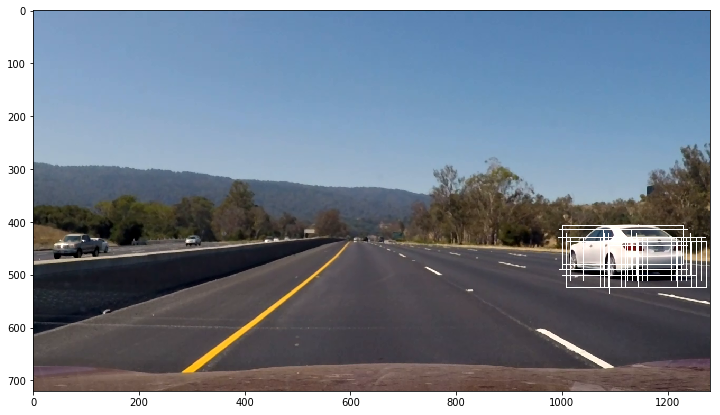

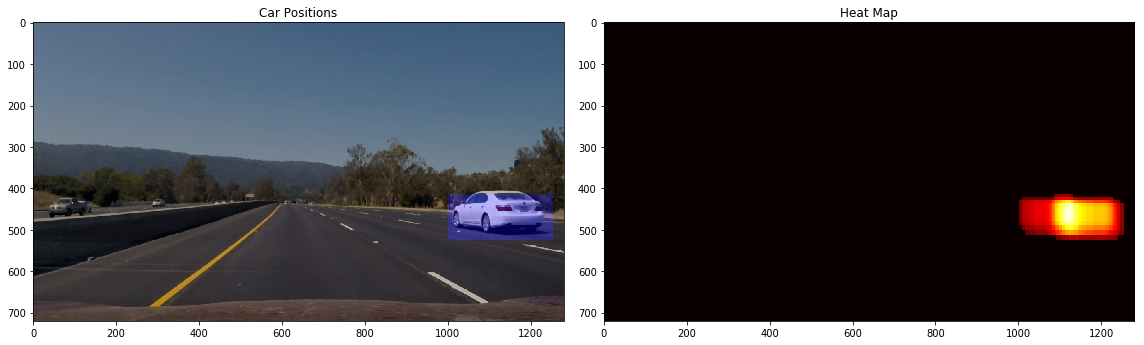

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


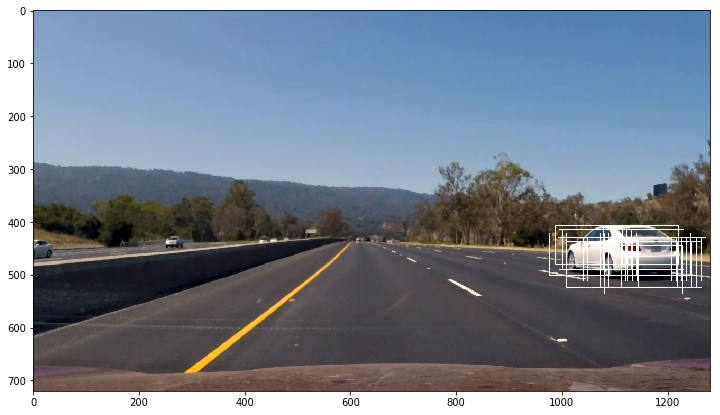

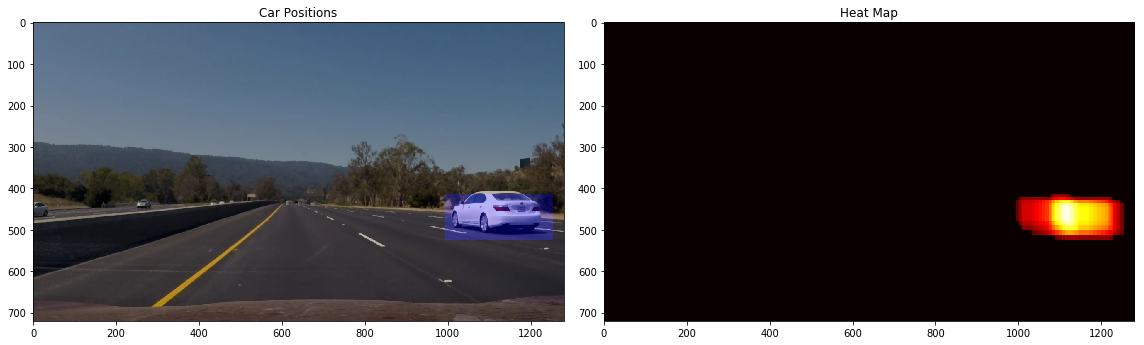

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


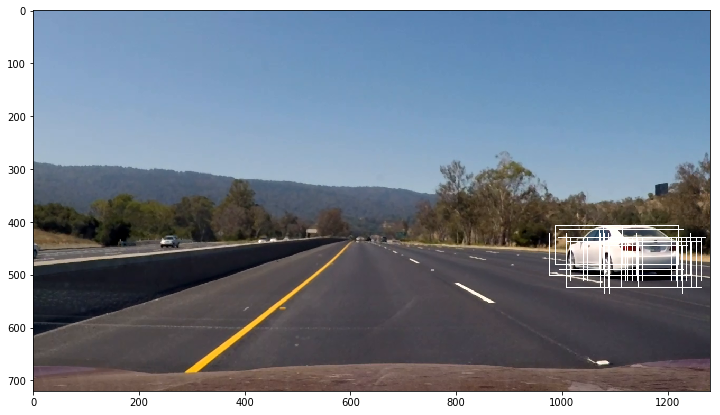

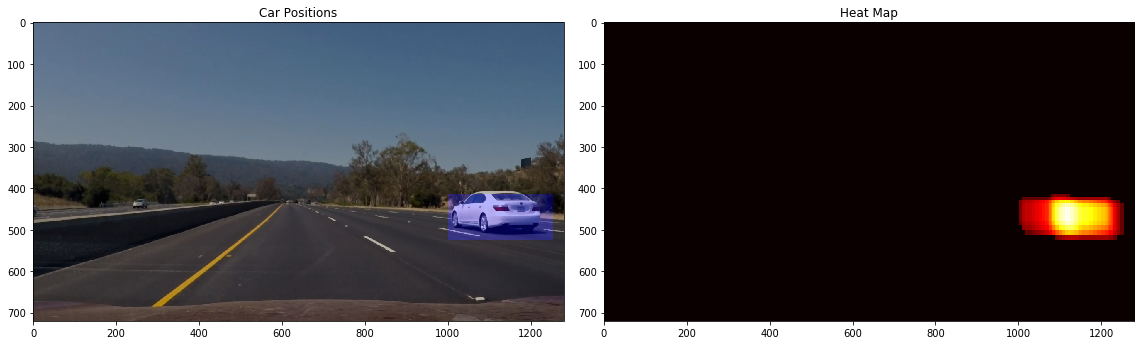

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


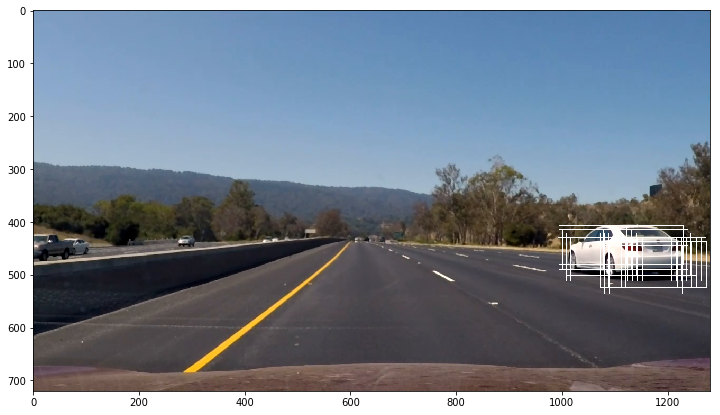

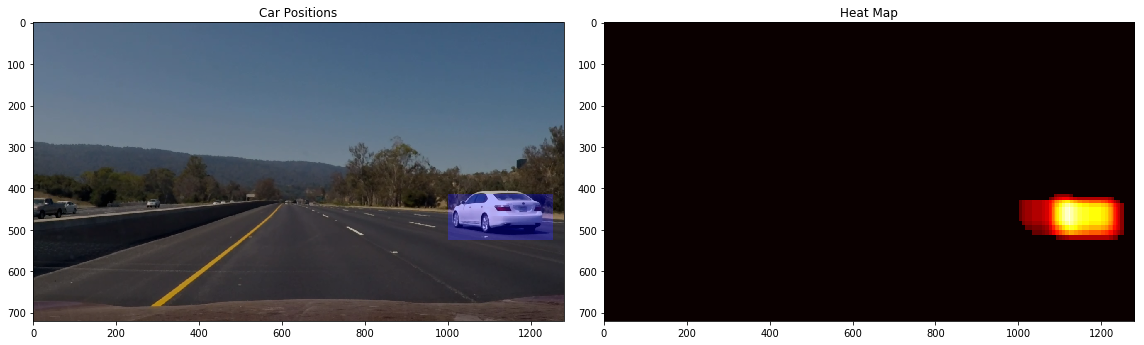

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


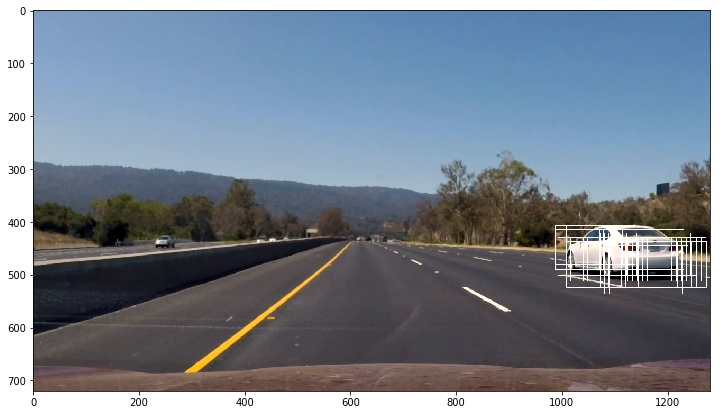

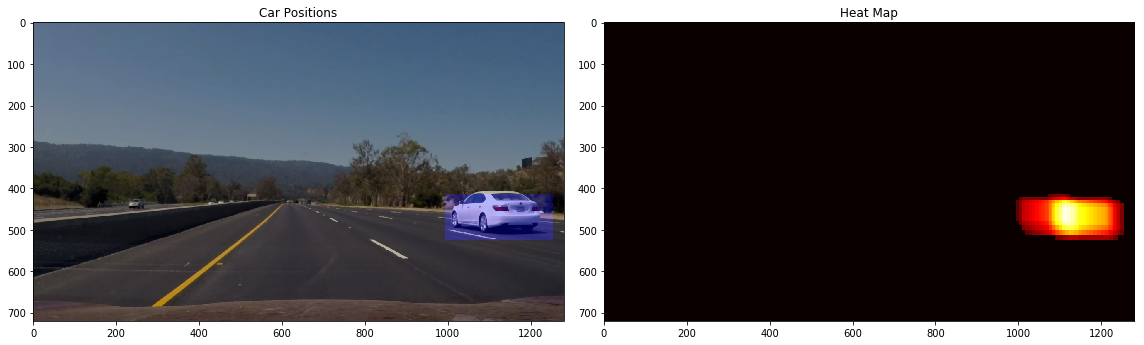

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


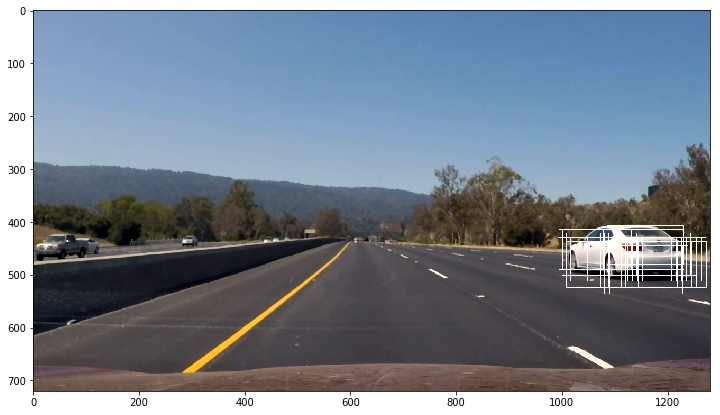

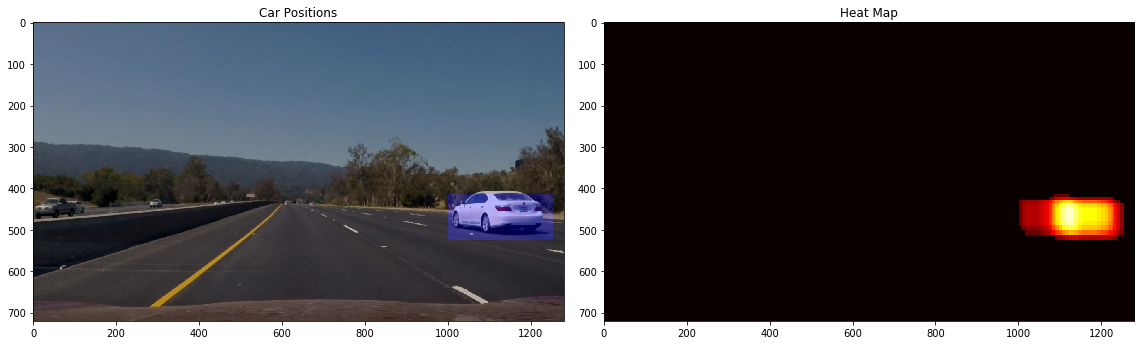

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


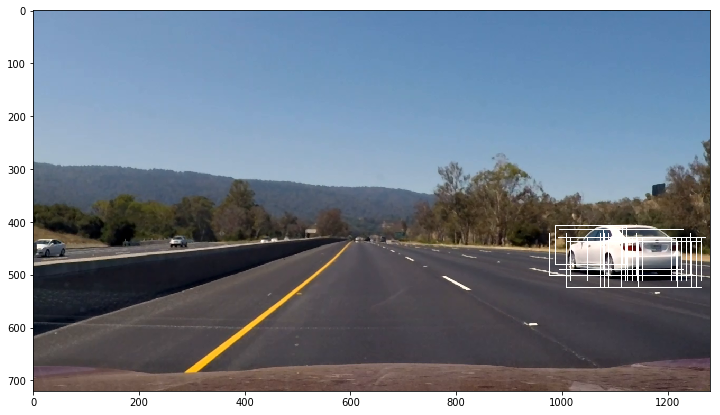

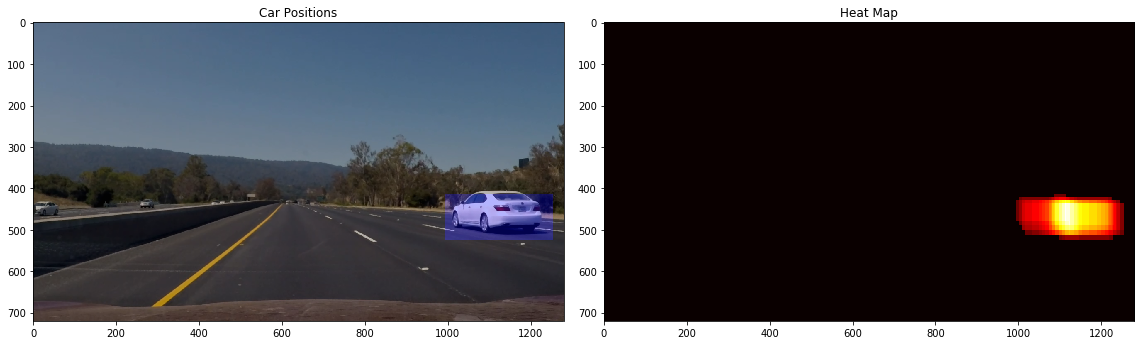

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


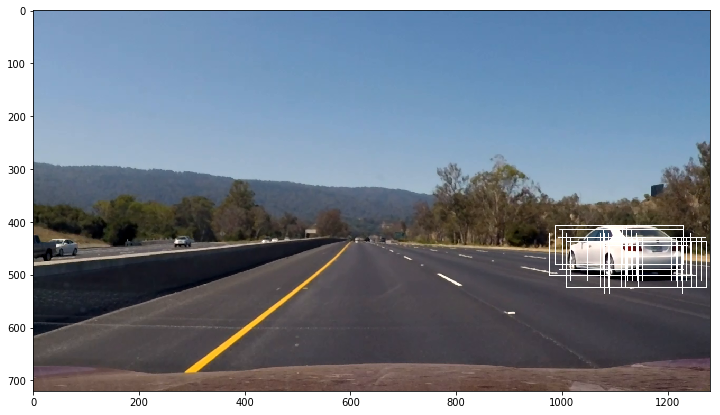

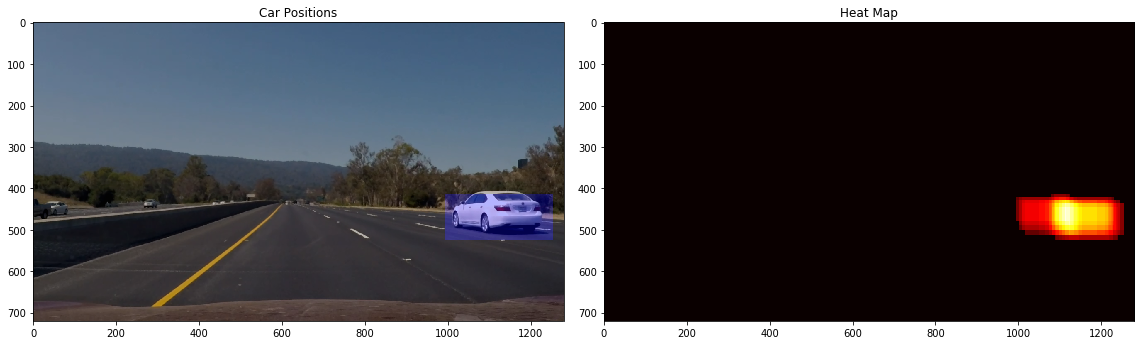

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


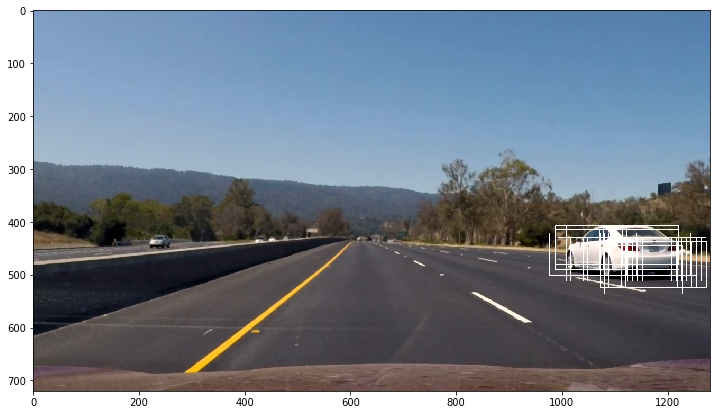

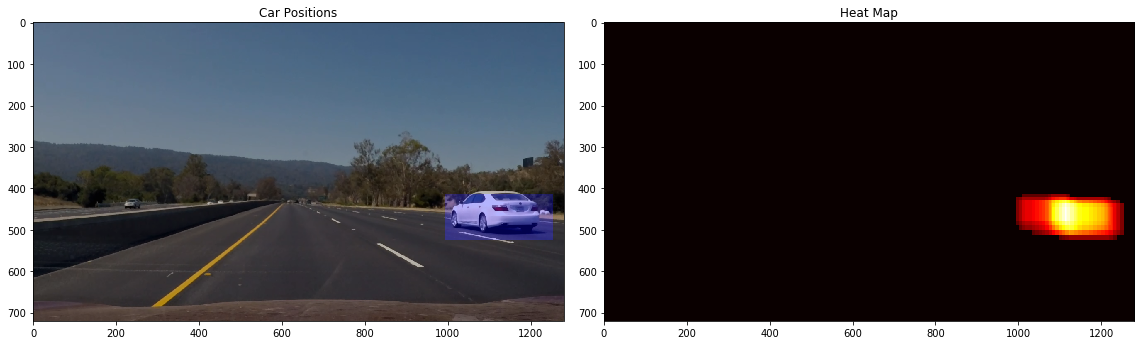

(720, 1280, 3)
win size 1902 1902
win size 1902 1902


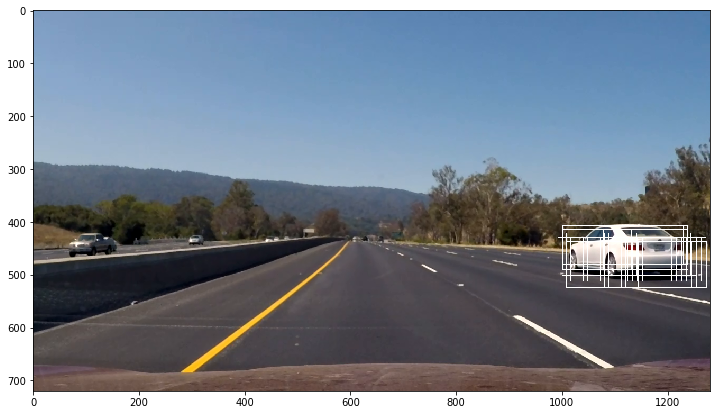

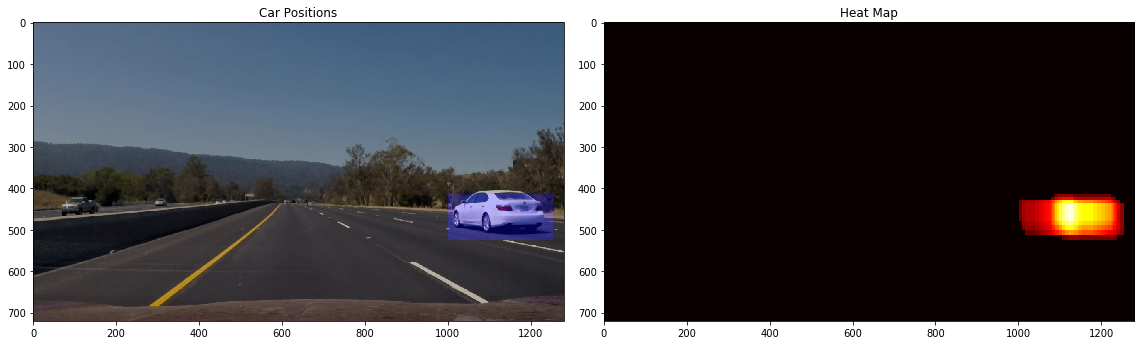

fin


In [17]:
import glob
from scipy.ndimage.measurements import label

"""
rImageGlob='./test_images/test*.png'
lImageGlob='./test_images/rev*.png'

if SVC_FILE=="./svc_pickle_CMP.p":
    image_globs = glob.glob(lImageGlob)
    image_globs.extend(glob.glob(rImageGlob))

else:
    if SVC_FILE=="./svc_pickle_MR.p":
        image_globs = glob.glob(rImageGlob)
    if SVC_FILE=="./svc_pickle_ML.p":
        image_globs = glob.glob(lImageGlob)
    

image_globs_extra = glob.glob('./try/image_*.png')    

image_globs.extend(image_globs_extra)
"""


image_globs= glob.glob('./try/image_*.png')    

loop=0

xhistory=[]
windows=[]
for xfile in  image_globs :
    image = x_imread(xfile)
    #image = mpimg.imread('bbox-example-image.jpg')
    draw_image = np.copy(image)
    if(len(xhistory)==0):
        xhistory=np.copy(image)*0
      
    print(xhistory.shape)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    x_start_stop=[0,image.shape[1]]
    
    if SVC_FILE=="./svc_pickle_ML.p":
         x_start_stop=[0,image.shape[1]//2]
    if SVC_FILE=="./svc_pickle_MR.p":
         x_start_stop=[image.shape[1]//2,image.shape[1]]
            
            
    #y_start_stop=[350,668]
    y_start_stop=[400,668]

    if len(windows)<=0:
        windows = my_slide_window3(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,min_window=64, xy_step=(0.11,0.11))
    
    edge=[]
    #low_threshold = 100
    #high_threshold = 200
    #edge = cv2.Canny(image, low_threshold, high_threshold)

    
    draw_image = draw_boxes(image, windows, color=(255,255, 255), thick=1) 
    #plt.figure(figsize=(16,9))
    #plt.imshow(draw_image)
    #continue
    
    """
    lng=min(x_start_stop[1]-x_start_stop[0],y_start_stop[1]-y_start_stop[0])
    #lng=(lng*3)//4
    step=0.1
    windows=[]
    
    
    
    while(lng>=64):
        #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
        #                    xy_window=(64, 64), xy_overlap=(0.1, 0.1))
        if loop==0:
            print('lng','step',lng,step)
        #win = my_slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
        #                    xy_window=(lng, lng), xy_step=(step, step))
        win = my_slide_window2(image,xhistory, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                             min_window=lng, xy_step=(step, step))
        
        windows.extend(win)
        lng=(lng*3)//4
    """   
    loop=loop+1    
    n=len(windows)
    print('win size',n,len(windows))

    #print(data.shape,data.dtype)
    #plt.imshow(data)
    #plt.show()

    if(len(edge)>0):
        for i in reversed(range(n)):
            #print(i)
            #print(len(windows))
            l=windows[i][0][0]
            t=windows[i][0][1]
            r=windows[i][1][0]
            b=windows[i][1][1]

            #print(l,t,r,b,edge.shape)
            area=edge[t:b,l:r]
            #print(area,area.shape)
            if(area.max()==0):
                del(windows[i])
    
    #plt.figure(figsize=(25,16))
    #plt.imshow(draw_boxes(image, windows, color=(255,255, 255), thick=1)  )
    #plt.show()
    
    print('win size',n,len(windows))

    hot_windows,cold_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)                       
    draw_image*=0
    #draw_image = draw_boxes(draw_image, cold_windows,color=(255, 0, 0 ), thick=1)                    
    draw_image = draw_boxes(draw_image, hot_windows, color=(255,255, 255), thick=1)                    
    #window_img= cv2.addWeighted(image, 0.7, draw_image, 0.3,2)   
    window_img= cv2.bitwise_or(image,draw_image)   

    ##########################################################3
    plt.figure(figsize=(13,7))
    plt.imshow(window_img)
 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    thr=4
    heat = apply_threshold(heat,thr)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    histrory=np.copy(image)*0
    histrory = draw_labeled_bboxes(histrory, labels,True)
    draw_img = cv2.addWeighted(image, 0.7, histrory , 0.3,2) 

    fig = plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

    
print('fin')   

In [ ]:
"""
img0 =cv2.imread(xfile)
img1 =mpimg.imread(xfile)
print(img0.max(),img1.max())

low_threshold = 100
high_threshold = 200
edge1 = cv2.Canny(img0, low_threshold, high_threshold)
data=np.clip(image*255,0,255).astype(np.uint8)
edge2 = cv2.Canny(data, low_threshold, high_threshold)
plt.figure()
plt.imshow(edge1)
plt.figure()
plt.imshow(edge2)
plt.show()
"""

In [19]:
import pickle

svc=[]
X_scaler=[]
color_space=[]
spatial_size=[]
hist_bins=[]
orient=[]
pix_per_cell=[]
hog_channel=[]
spatial_feat=[]
hist_feat=[]
hog_feat=[]

    
def detection_continuous(image,heat,xwindows,dist_pickle_CMP):
    global svc
    global X_scaler
    global color_space
    global spatial_size
    global hist_bins
    global orient
    global pix_per_cell
    global hog_channel
    global spatial_feat
    global hist_feat
    global hog_feat
    labels=[]
    
    thr=6
 
    if(len(heat)==0):
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
    else:
        heat =heat//2
        heat =np.clip(heat, 0 ,thr-1)
        
        
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    x_start_stop=[0,image.shape[1]]
    y_start_stop=[400,668]
    lng=min(x_start_stop[1]-x_start_stop[0],y_start_stop[1]-y_start_stop[0])
    #lng=(lng*3)//4

    if(len(xwindows)<=0):

        print('initialize parameters')
        svc=dist_pickle_CMP["svc"]
        X_scaler=dist_pickle_CMP["scaler"]        
        color_space=dist_pickle_CMP["color_space"]
        spatial_size=dist_pickle_CMP["spatial_size"]
        hist_bins=dist_pickle_CMP["hist_bins"]
        orient=dist_pickle_CMP["orient"]
        pix_per_cell=dist_pickle_CMP["pix_per_cell"]
        hog_channel=dist_pickle_CMP["hog_channel"]
        spatial_feat=dist_pickle_CMP["spatial_feat"]
        hist_feat=dist_pickle_CMP["hist_feat"]
        hog_feat=dist_pickle_CMP["hog_feat"]

        xwindows= my_slide_window3(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,min_window=64, xy_step=(0.11,0.11))
    #n=len(xwindows)
    #print('win size (1)',n,len(xwindows))



    hot_windows,cold_windows = search_windows(image, xwindows, svc, X_scaler, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)     


    #draw_image*=0
    #draw_image = draw_boxes(draw_image, hot_windows, color=(255,255, 255), thick=1)                    
    #window_img= cv2.addWeighted(image, 0.7, draw_image, 0.3,2)   

    ##########################################################3


    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    ##加算結果を残す

    # Apply threshold to help remove false positives
    exheat = apply_threshold(heat,thr)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(exheat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
            
    #current_frame=image.copy()*0
    #next_history =image.copy()*0
    #
    
    draw_img = draw_labeled_bboxes(image.copy(), labels,False)
 
    
    return draw_img,heat,labels,windows


###########################################################################################
#dist_pickle_MLR =[  pickle.load( open("./svc_pickle_ML.p", "rb" ) )
#                   ,pickle.load( open("./svc_pickle_MR.p", "rb" ) ) ]

                               
def detection_continuous_dual(image,heat,gbl_windows,dist_pickle_MLR):
    global svc
    global X_scaler
    global color_space
    global spatial_size
    global hist_bins
    global orient
    global pix_per_cell
    global hog_channel
    global spatial_feat
    global hist_feat
    global hog_feat   
    l_labels=[]
    r_labels=[]
    
    thr=3
 
    if(len(heat)==0):
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
    else:
        heat =heat//2
        heat =np.clip(heat, 0 ,thr-1)
        
    for LR in range(2):
        # Uncomment the following line if you extracted training
        # data from .png images (scaled 0 to 1 by mpimg) and the
        # image you are searching is a .jpg (scaled 0 to 255)
        #image = image.astype(np.float32)/255

        #画面の探索範囲を左右で区分け
        x_start_stop=[image.shape[1]//2,image.shape[1]]
        if LR==0:
             x_start_stop=[0,image.shape[1]//2]

        y_start_stop=[400,668]
        lng=min(x_start_stop[1]-x_start_stop[0],y_start_stop[1]-y_start_stop[0])
        #lng=(lng*3)//4
       
        if(len(gbl_windows[0])<=0):
            print('initialize parameters')
            svc=dist_pickle_MLR[LR]["svc"]
            X_scaler=dist_pickle_MLR[LR]["scaler"]        
            color_space=dist_pickle_MLR[LR]["color_space"]
            spatial_size=dist_pickle_MLR[LR]["spatial_size"]
            hist_bins=dist_pickle_MLR[LR]["hist_bins"]
            orient=dist_pickle_MLR[LR]["orient"]
            pix_per_cell=dist_pickle_MLR[LR]["pix_per_cell"]
            hog_channel=dist_pickle_MLR[LR]["hog_channel"]
            spatial_feat=dist_pickle_MLR[LR]["spatial_feat"]
            hist_feat=dist_pickle_MLR[LR]["hist_feat"]
            hog_feat=dist_pickle_MLR[LR]["hog_feat"]
        if(len(gbl_windows[LR])<=0):
            gbl_windows[LR] = my_slide_window3(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,min_window=64, xy_step=(0.11,0.11))
        #n=len(windows)
        #print('win size (1)',n,len(windows))


        #print('win size (2)',n,len(windows))

            
        hot_windows,cold_windows = search_windows(image, gbl_windows[LR], svc, X_scaler, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)     
        
        
        #draw_image*=0
        #draw_image = draw_boxes(draw_image, hot_windows, color=(255,255, 255), thick=1)                    
        #window_img= cv2.addWeighted(image, 0.7, draw_image, 0.3,2)   
        
        ##########################################################3

            
        # Add heat to each box in box list
        heat = add_heat(heat,hot_windows)
        ##加算結果を残す

        # Apply threshold to help remove false positives
        exheat = apply_threshold(heat,thr)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(exheat, 0, 255)

        # Find final boxes from heatmap using label function
        if(LR==0):
            l_labels = label(heatmap)
        else:    
            r_labels = label(heatmap)
            
            
    #current_frame=image.copy()*0
    #next_history =image.copy()*0
    #
    
    draw_img=image.copy()
    draw_img = draw_labeled_bboxes(draw_img, l_labels,False)

    
    draw_img = draw_labeled_bboxes(draw_img, r_labels,False)

    
    return draw_img,heat,l_labels,r_labels,gbl_windows



print('fin')

fin


['./try/image_291.png', './try/image_296.png', './try/image_297.png', './try/image_293.png', './try/image_298.png', './try/image_292.png', './try/image_295.png', './try/image_294.png', './try/image_299.png', './try/image_290.png']
initialize parameters


/home/uda/.conda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


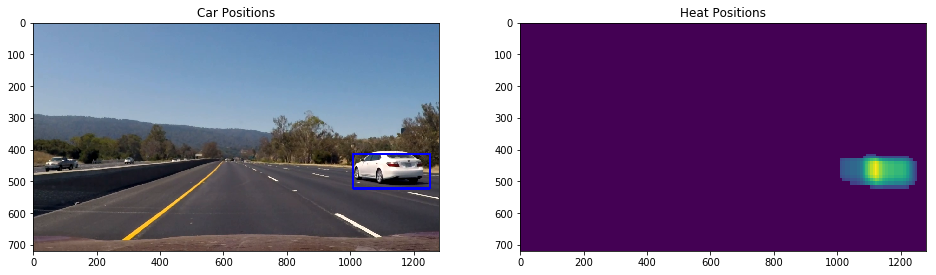

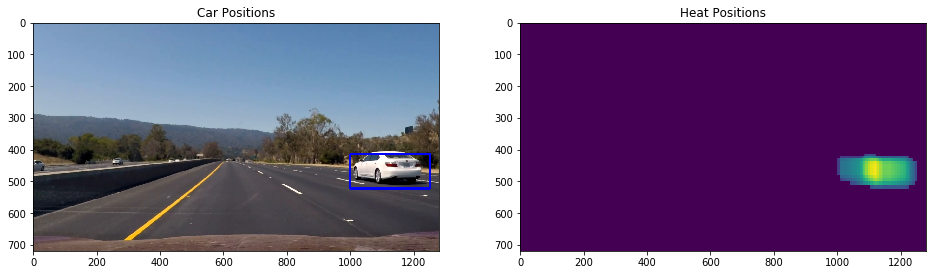

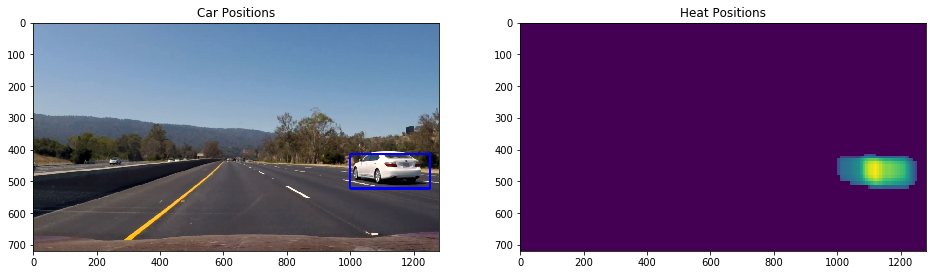

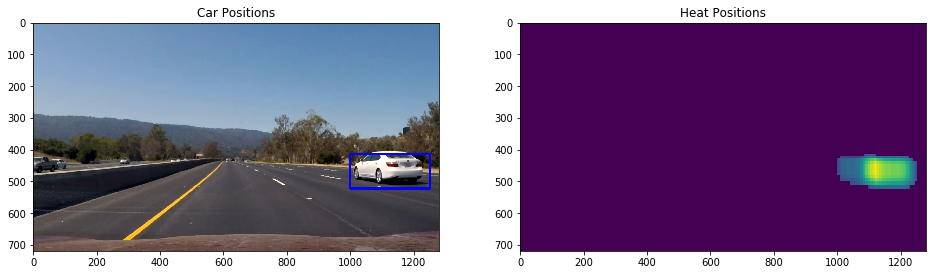

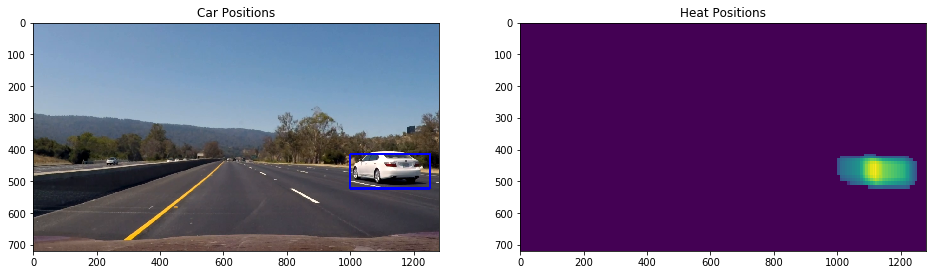

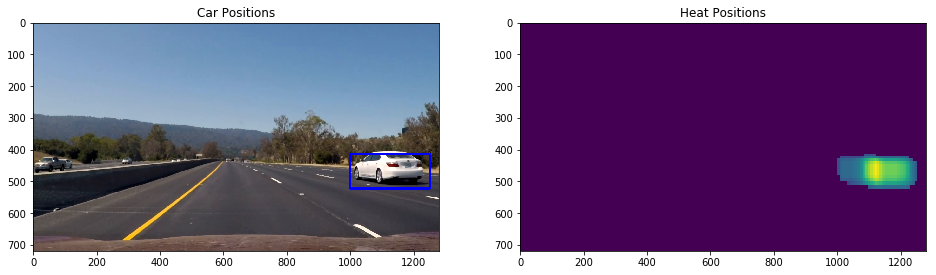

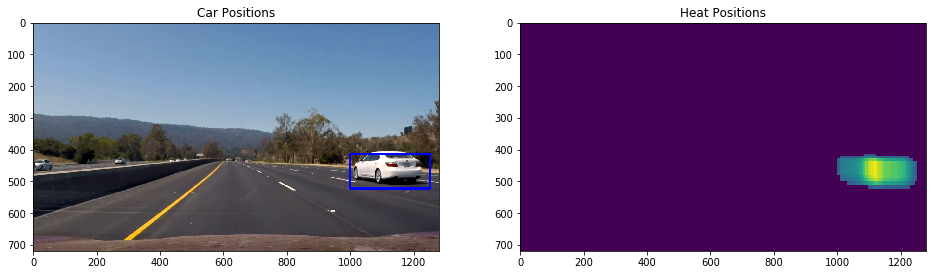

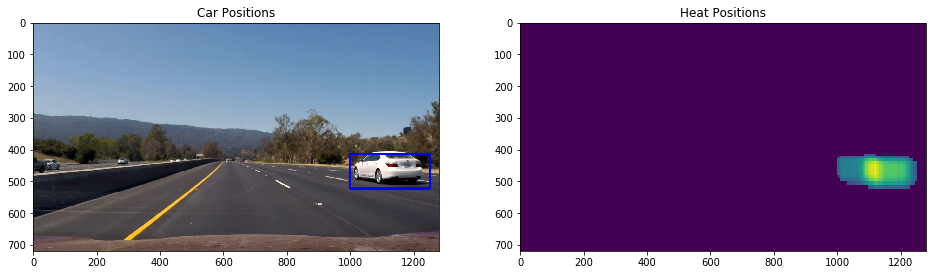

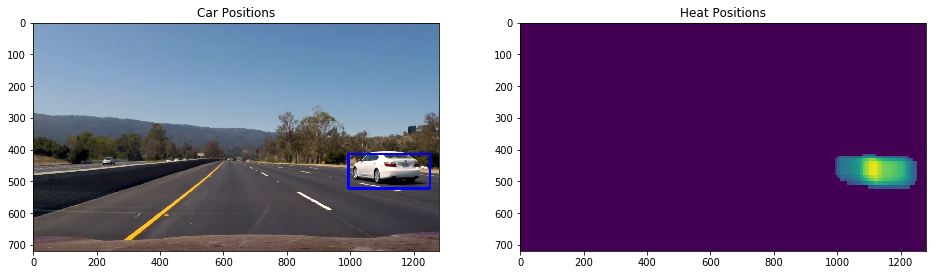

In [ ]:
image_globs_R = glob.glob('./test_images/test*.png')
image_globs_L = glob.glob('./test_images/rev*.png')

#image_globs=image_globs_L.copy()
#image_globs.extend(image_globs_R)
image_globs = glob.glob('./try/image_*.png')

print(image_globs)

dist_pickle_MLR =[  pickle.load( open("./svc_pickle_ML.p", "rb" ) )
                   ,pickle.load( open("./svc_pickle_MR.p", "rb" ) ) ]
gbl_windows_dual=[]
labels_l=[]
labels_r=[]


gbl_heat=[]



dist_pickle_CMP =  pickle.load( open("./svc_pickle_CMP.p", "rb" ) )
gbl_windows_single=[]
labels=[]

def proc_image(image):
    global gbl_heat
  #  global dist_pickle_MLR                          
  #  global gbl_windows_dual
  #  draw_img,gbl_heat,l_labels,r_labels,,gbl_windows_dual=detection_continuous_dual(image,gbl_heat,gbl_windows_dual,dist_pickle_MLR)
   
    global dist_pickle_CMP
    global gbl_windows_single
    global labels
    draw_img,gbl_heat,labels,gbl_windows_single=detection_continuous(image,gbl_heat,gbl_windows_single,dist_pickle_CMP)
    return draw_img

for xfile in  image_globs :
    image = x_imread(xfile)
    draw_img=proc_image(image)
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(gbl_heat)
    plt.title('Heat Positions')
    plt.show()

In [23]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

dist_pickle_MLR =[  pickle.load( open("./svc_pickle_ML.p", "rb" ) )
                   ,pickle.load( open("./svc_pickle_MR.p", "rb" ) ) ]
gbl_windows_dual=[]
labels_l=[]
labels_r=[]


gbl_heat=[]



dist_pickle_CMP =  pickle.load( open("./svc_pickle_CMP.p", "rb" ) )
gbl_windows_single=[]
labels=[]


prj_output = 'videos_output/project_test.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

#clip1  = VideoFileClip("./project_video.mp4").subclip(0,1)
clip1  = VideoFileClip("./project_video.mp4")


#white_clip  =  clip1.fl_image(test_image) #NOTE: this function expects color images!!
white_clip  =  clip1.fl_image(proc_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(prj_output, audio=False)



initialize parameters
[MoviePy] >>>> Building video videos_output/project_test.mp4
[MoviePy] Writing video videos_output/project_test.mp4


100%|█████████▉| 1260/1261 [3:55:48<00:11, 11.29s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_test.mp4 

CPU times: user 3h 55min 45s, sys: 2.75 s, total: 3h 55min 48s
Wall time: 3h 55min 49s


In [22]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(prj_output))